<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I - Introduction & préparation des données</h2>

<p>
Cette section a pour objectif de comparer deux stratégies de fusion des modèles
texte précédemment entraînés : une <b>fusion pondérée (blending)</b> et une
<b>fusion par stacking</b> reposant sur l’apprentissage d’un méta-classifieur.
Ces deux approches permettent de combiner les prédictions de plusieurs modèles,
mais reposent sur des hypothèses et des niveaux de complexité différents.
</p>

<p>
Afin de garantir une comparaison équitable et méthodologiquement rigoureuse, le
jeu de validation est scindé en deux parties distinctes selon une proportion
<b>70&nbsp;/&nbsp;30</b>. La première partie est utilisée pour
<b>l’apprentissage du méta-classifieur</b> dans le cadre du stacking (ou, plus
généralement, pour l’estimation des paramètres de fusion), tandis que la seconde
partie est exclusivement réservée à <b>l’évaluation finale</b> des deux
stratégies de fusion. Cette séparation permet d’éviter toute fuite de données et
de comparer les méthodes sur un jeu strictement indépendant de leur
paramétrisation.
</p>

<p>
Avant de procéder à la fusion, les sorties des modèles de deep learning sont
préparées de manière homogène. Les modèles basés sur des architectures
transformers produisent en sortie des <b>logits</b>, qui ne constituent pas des
probabilités directement interprétables. Ces logits sont donc <b>calibrés a
posteriori</b> à l’aide d’une méthode de <b>temperature scaling</b>, consistant à
apprendre un paramètre de température sur une sous-partie du jeu de validation,
puis à appliquer une fonction <b>softmax</b> afin d’obtenir des probabilités
calibrées. Cette étape vise à améliorer la cohérence probabiliste des prédictions,
sans modifier les classes prédites.
</p>

<p>
À l’inverse, le modèle basé sur une vectorisation <b>TF-IDF</b> et une
<b>SVM</b> produit déjà des probabilités calibrées, celles-ci ayant été obtenues
via une procédure de calibration dédiée lors de son entraînement (voir notebook
<i>text_04_vectorization.ipynb</i>). Aucune étape supplémentaire de calibration
n’est donc nécessaire pour ce modèle.
</p>

<p>
Une fois l’ensemble des sorties probabilistes harmonisées, les deux stratégies de
fusion — blending pondéré et stacking — sont mises en œuvre et évaluées sur le
même sous-ensemble d’évaluation, afin d’analyser leurs performances respectives
en termes de <b>F1-score pondéré</b> et de <b>log loss</b>.
</p>

<div/>

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')
from data import load_data
from utils.calibration import fit_temperature, calibrated_probas
from visualization import plot_classification_report, plot_f1_comparison_with_delta

from sklearn.preprocessing import LabelEncoder

In [2]:
_, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
# Probabilités et logits sur la validation

logits_val_cam = np.load("../predictions/text/logits_camembert_val.npy")
logits_val_xlmr = np.load("../predictions/text/logits_xlmr_best_loss_val.npy")
P_val_tfidf = np.load("../predictions/text/proba_vec_val.npy")
logits_test_cam = np.load("../predictions/text/logits_camembert_test.npy")
logits_test_xlmr = np.load("../predictions/text/logits_xlmr_best_loss_test.npy")
P_test_tfidf = np.load("../predictions/text/proba_vec_test.npy")


# calibration des modèles
T_cam = fit_temperature(logits_val_cam, y_val)
T_xlmr = fit_temperature(logits_val_xlmr, y_val)
P_val_cam = calibrated_probas(logits_val_cam, T_cam)
P_val_xlmr = calibrated_probas(logits_val_xlmr, T_xlmr)
P_test_cam = calibrated_probas(logits_test_cam, T_cam)
P_test_xlmr = calibrated_probas(logits_test_xlmr, T_xlmr)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>II - Blending</h2>

<p>
Le <b>blending</b> est une stratégie de fusion tardive (<i>late fusion</i>) qui
consiste à combiner les sorties probabilistes de plusieurs modèles afin
d’obtenir une prédiction finale plus robuste. Contrairement au stacking, le
blending ne repose pas sur l’apprentissage d’un méta-classifieur, mais sur une
<b>combinaison linéaire pondérée</b> des probabilités produites par chaque modèle.
</p>

<p>
Formellement, la probabilité finale associée à une classe est définie comme une
somme pondérée des probabilités individuelles :
</p>

<p style="text-align:center;">
\( P = \sum_i w_i \cdot P_i \quad \text{avec} \quad \sum_i w_i = 1 \)
</p>

<p>
où \(P_i\) correspond aux probabilités prédites par le modèle \(i\), et \(w_i\)
au poids associé à ce modèle. Ces poids traduisent le degré de confiance accordé
à chaque source d’information dans la décision finale.
</p>

</div>

<div style="background:#f8f8ff; padding:14px; border-radius:6px">

<p>
Afin d’évaluer l’apport réel de chaque modèle dans la fusion, trois
configurations de blending sont comparées :
</p>

<ul>
  <li>
    <b>CamemBERT-large + XLM-R</b>, afin d’évaluer l’apport d’un modèle multilingue
    en complément du modèle monolingue principal ;
  </li>
  <li>
    <b>CamemBERT-large + TF-IDF</b>, afin de mesurer l’intérêt de signaux lexicaux
    classiques en complément des représentations neuronales ;
  </li>
  <li>
    <b>CamemBERT-large + XLM-R + TF-IDF</b>, correspondant à une fusion combinant
    l’ensemble des sources d’information disponibles.
  </li>
</ul>

<p>
Ces comparaisons permettent de mesurer la contribution marginale de chaque
composant, et en particulier celle de <b>XLM-R</b>, dans un cadre contrôlé et
méthodologiquement cohérent.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les poids du blending sont déterminés à partir de la <b>log loss</b> obtenue par
chaque modèle sur le jeu de validation. La log loss, également appelée
<i>cross-entropy</i>, mesure la qualité probabiliste des prédictions : elle
pénalise fortement les prédictions incorrectes réalisées avec une forte
confiance, et favorise les modèles produisant des probabilités mieux calibrées.
</p>

<p>
Afin de refléter cette notion de fiabilité probabiliste, les poids sont définis
comme étant proportionnels à l’inverse de la log loss :
</p>

<p style="text-align:center;">
\( w_i \propto \frac{1}{\text{log\_loss}_i} \)
</p>

<p>
Cette transformation possède une interprétation mathématique directe : un
modèle présentant une log loss plus faible (donc des probabilités plus fiables)
se voit attribuer un poids plus élevé dans la fusion. Les coefficients sont
ensuite normalisés afin de sommer à un, garantissant ainsi une combinaison
convexe des probabilités.
</p>

<p>
Cette approche présente plusieurs avantages : elle ne nécessite aucun paramètre
supplémentaire à apprendre, évite toute optimisation directe des poids sur les
données d’évaluation, et respecte la hiérarchie des modèles observée
individuellement. Les poids ainsi obtenus sont ensuite figés et utilisés pour
l’évaluation des différentes stratégies de blending.
</p>

</div>


In [4]:
def normalize_probas(P, eps=1e-12):
    """
    Normalise les probabilités pour que chaque ligne somme à 1.
    """
    P = np.clip(P, eps, 1.0)
    return P / P.sum(axis=1, keepdims=True)

def weights_from_logloss(log_losses: dict) -> dict:
    """
    Calcule des poids proportionnels à l'inverse de la log loss
    et les normalise pour sommer à 1.
    """
    inv = {k: 1.0 / v for k, v in log_losses.items()}
    total = sum(inv.values())
    return {k: v / total for k, v in inv.items()}

# --- Probabilités disponibles ---
probas = {
    "camembert": P_val_cam,
    "xlmr": P_val_xlmr,
    "tfidf": P_val_tfidf,
}

# --- Configurations de blending ---
configs = {
    "CamemBERT + XLM-R": ["camembert", "xlmr"],
    "CamemBERT + TF-IDF": ["camembert", "tfidf"],
    "CamemBERT + XLM-R + TF-IDF": ["camembert", "xlmr", "tfidf"],
}

rows = []

for config_name, models in configs.items():

    # 1️⃣ Calcul des log loss individuelles (sur VAL_WEIGHTS ou y_val selon ton setup)
    log_losses = {
        m: log_loss(y_val, probas[m])
        for m in models
    }

    # 2️⃣ Calcul des poids par inverse de log loss
    weights = weights_from_logloss(log_losses)

    # 3️⃣ Blending pondéré
    P_blend = sum(weights[m] * probas[m] for m in models)
    P_blend = normalize_probas(P_blend)

    # 4️⃣ Évaluation sur eval_idx
    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    # 5️⃣ Stockage des résultats (0 pour modèles absents)
    rows.append({
        "configuration": config_name,
        "w_camembert": weights.get("camembert", 0.0),
        "w_xlmr": weights.get("xlmr", 0.0),
        "w_tfidf": weights.get("tfidf", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending = pd.DataFrame(rows).set_index("configuration")
df_blending.round(4)

,w_camembert,w_xlmr,w_tfidf,f1_weighted,log_loss
configuration,,,,,
CamemBERT + XLM-R,0.5292,0.4708,0.0000,0.9101,0.4094
CamemBERT + TF-IDF,0.4990,0.0000,0.5010,0.9108,0.3884
CamemBERT + XLM-R + TF-IDF,0.3456,0.3075,0.3469,0.9110,0.3717


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des résultats du blending</h4>

<p>
Les résultats obtenus pour les différentes configurations de blending mettent en
évidence des écarts modérés mais cohérents, tant en termes de
<b>F1-score pondéré</b> que de <b>log loss</b>. Ces résultats permettent d’analyser
l’apport relatif de chaque source d’information dans une stratégie de fusion
pondérée basée sur la qualité probabiliste individuelle des modèles.
</p>

<p>
La configuration <b>CamemBERT + XLM-R</b> présente les performances les plus faibles
parmi les configurations évaluées. Bien que XLM-R bénéficie d’un poids comparable
à celui de CamemBERT, cette fusion n’apporte qu’un gain limité. Ce comportement
suggère une <b>forte corrélation</b> entre les deux modèles transformers, qui
réduit la diversité exploitable dans une fusion linéaire simple.
</p>

<p>
La configuration <b>CamemBERT + TF-IDF</b> se révèle plus intéressante, avec une
<b>amélioration notable de la log loss</b> tout en conservant un F1-score du même
ordre de grandeur. Le poids attribué au TF-IDF, proche de celui de CamemBERT,
indique que les signaux lexicaux apportent une <b>information complémentaire
robuste</b>, en particulier du point de vue probabiliste.
</p>

<p>
La configuration <b>CamemBERT + XLM-R + TF-IDF</b> obtient les meilleurs résultats
globaux. Elle présente le <b>F1-score pondéré le plus élevé</b> ainsi qu’une
<b>log loss parmi les plus faibles</b>, traduisant un bon compromis entre
performance de classification et qualité probabiliste. Les poids relativement
équilibrés entre les trois modèles suggèrent que XLM-R, bien que peu performant
lorsqu’il est utilisé seul, contribue positivement lorsqu’il est combiné à des
sources d’information hétérogènes.
</p>

<p>
Ces résultats confirment que le <b>TF-IDF</b> constitue le complément le plus
robuste à <b>CamemBERT</b>, tandis que <b>XLM-R</b> apporte un signal marginal mais
utile dans une fusion plus riche.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III - Stacking</h2>

<p>
Le <b>stacking</b> est une stratégie de fusion tardive plus générale que le
blending, qui consiste à apprendre explicitement une combinaison optimale des
modèles à l’aide d’un <b>méta-classifieur</b>. Contrairement au blending, où les
poids sont fixés a priori, le stacking cherche à exploiter les sorties
probabilistes des modèles de base comme des <b>features d’entrée</b> pour un
modèle supplémentaire chargé de produire la prédiction finale.
</p>

<p>
Dans ce cadre, chaque échantillon est représenté par la concaténation des
probabilités prédites par les différents modèles, et le méta-modèle apprend à
pondérer ces informations en fonction de leur utilité respective.
</p>

<p>
Le méta-classifieur retenu pour le stacking est une <b>régression logistique</b>.
Ce choix est motivé par plusieurs considérations méthodologiques. La régression
logistique constitue un modèle linéaire simple, bien adapté à la combinaison de
probabilités, et permet d’apprendre des pondérations par classe tout en limitant
le risque de sur-apprentissage.
</p>

<p>
Dans un contexte où les modèles de base sont fortement corrélés et où le volume
de données disponible pour l’apprentissage du méta-modèle est limité, ce choix
représente un compromis pertinent entre expressivité et robustesse. Des
méta-modèles plus complexes n’ont volontairement pas été explorés afin de
préserver la stabilité de l’approche.
</p>

<p>
Le méta-classifieur est entraîné sur une sous-partie du jeu de validation,
distincte de celle utilisée pour l’évaluation finale, conformément au protocole
décrit précédemment. Cette séparation permet d’éviter toute fuite de données et
de garantir une comparaison équitable entre les différentes stratégies de
fusion.
</p>

<p>
Afin de comparer directement le stacking au blending, les <b>mêmes trois
configurations</b> sont évaluées :
</p>

<ul>
  <li><b>CamemBERT-large + XLM-R</b></li>
  <li><b>CamemBERT-large + TF-IDF</b></li>
  <li><b>CamemBERT-large + XLM-R + TF-IDF</b></li>
</ul>

<p>
Cette analyse permet d’évaluer si l’apprentissage explicite d’une combinaison
des modèles permet d’améliorer les performances par rapport à une fusion
pondérée simple, ou si une approche plus contrainte se révèle plus robuste dans
ce contexte.
</p>

</div>


In [7]:
rows = []

for config_name, models in configs.items():

    # 1️⃣ Construction des features meta (concaténation des probabilités)
    X_meta = np.concatenate([probas[m] for m in models], axis=1)

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    # 2️⃣ Entraînement du méta-classifieur
    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    # 3️⃣ Prédictions sur le jeu d’évaluation
    P_eval = meta_model.predict_proba(X_meta_eval)

    # Sécurité : normalisation explicite
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    # 4️⃣ Métriques
    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    # 5️⃣ Stockage des résultats
    rows.append({
        "configuration": config_name,
        "f1_weighted": f1,
        "log_loss": ll,
    })


df_stacking = pd.DataFrame(rows).set_index("configuration")


scores = pd.concat([df_blending[['f1_weighted', 'log_loss']], df_stacking], axis=0)#.reset_index(['blending']*3+['stacking']*3)
scores.index = ['blending - ' + idx if i < 3 else 'stacking - ' + idx for i, idx in enumerate(scores.index)]
scores

,f1_weighted,log_loss
blending - CamemBERT + XLM-R,0.910107,0.409364
blending - CamemBERT + TF-IDF,0.910792,0.388435
blending - CamemBERT + XLM-R + TF-IDF,0.911026,0.371713
stacking - CamemBERT + XLM-R,0.907679,0.384854
stacking - CamemBERT + TF-IDF,0.910292,0.360559
stacking - CamemBERT + XLM-R + TF-IDF,0.909031,0.343349


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les résultats présentés ci-dessus permettent de comparer directement les deux
stratégies de fusion — <b>blending pondéré</b> et <b>stacking</b> — sur les mêmes
configurations de modèles et le même jeu d’évaluation. Cette comparaison met en
évidence des différences modérées mais systématiques, révélatrices de l’impact
de la complexité de la méthode de fusion sur la performance et la qualité
probabiliste des prédictions.
</p>

<p>
Pour les configurations à deux modèles, les performances en <b>F1-score
pondéré</b> obtenues par le blending et le stacking sont globalement proches.
Toutefois, le stacking conduit dans la plupart des cas à une <b>dégradation du
F1</b> par rapport au blending, en particulier pour la configuration
<b>CamemBERT + XLM-R</b>. En revanche, le stacking peut produire une <b>log loss
plus faible</b>, notamment pour les configurations intégrant le TF-IDF, ce qui
indique une amélioration ponctuelle de la calibration probabiliste.
</p>

<p>
La configuration <b>CamemBERT + TF-IDF</b> illustre ce compromis : le stacking
permet une légère amélioration de la log loss par rapport au blending, mais sans
gain correspondant en F1-score. Ce comportement suggère que le méta-classifieur
parvient à lisser les probabilités, sans pour autant améliorer la qualité des
décisions finales.
</p>

<p>
La configuration <b>CamemBERT + XLM-R + TF-IDF</b> met en évidence les limites du
stacking dans ce contexte. Bien que cette approche conduise à la <b>log loss la
plus faible</b> parmi l’ensemble des configurations testées, elle s’accompagne
d’une <b>diminution du F1-score pondéré</b> par rapport au blending. Ce résultat
suggère que l’apprentissage explicite de la combinaison des modèles privilégie
une meilleure calibration au détriment de la performance de classification,
probablement en raison de la forte corrélation entre les modèles de base et du
volume limité de données disponibles pour l’apprentissage du méta-classifieur.
</p>

<p>
Ces observations confirment que, dans un contexte où un modèle principal
(CamemBERT-large) domine largement la performance de classification, et où les
modèles complémentaires apportent principalement des signaux marginaux, une
stratégie de fusion plus contrainte et plus simple peut s’avérer plus robuste
qu’une approche plus flexible mais plus sensible au sur-ajustement.
</p>

<p>
Au regard de l’ensemble des résultats, la configuration <b>Blending –
CamemBERT + XLM-R + TF-IDF</b> apparaît comme le <b>meilleur compromis global</b>.
Elle obtient le F1-score pondéré le plus élevé tout en conservant une log loss
raisonnablement faible, assurant un équilibre pertinent entre performance de
classification et qualité probabiliste.
</p>

<p>
En conséquence, cette configuration est retenue comme <b>modèle texte final</b>
pour la suite du projet. Elle permet d’exploiter efficacement la complémentarité
entre représentations neuronales monolingues et multilingues ainsi que signaux
lexicaux classiques, tout en maintenant une stratégie de fusion simple, stable
et méthodologiquement robuste.
</p>



<h2>IV - Evaluation du modèle de texte final</h2>

<p>
Dans la section suivante, le modèle texte retenu est évalué sur le <b>jeu de
test final</b>, strictement indépendant des phases de sélection et de fusion.
Cette évaluation permet de mesurer la capacité de généralisation réelle du
modèle fusionné et de valider les choix méthodologiques effectués tout au long
du processus.
</p>

</div>


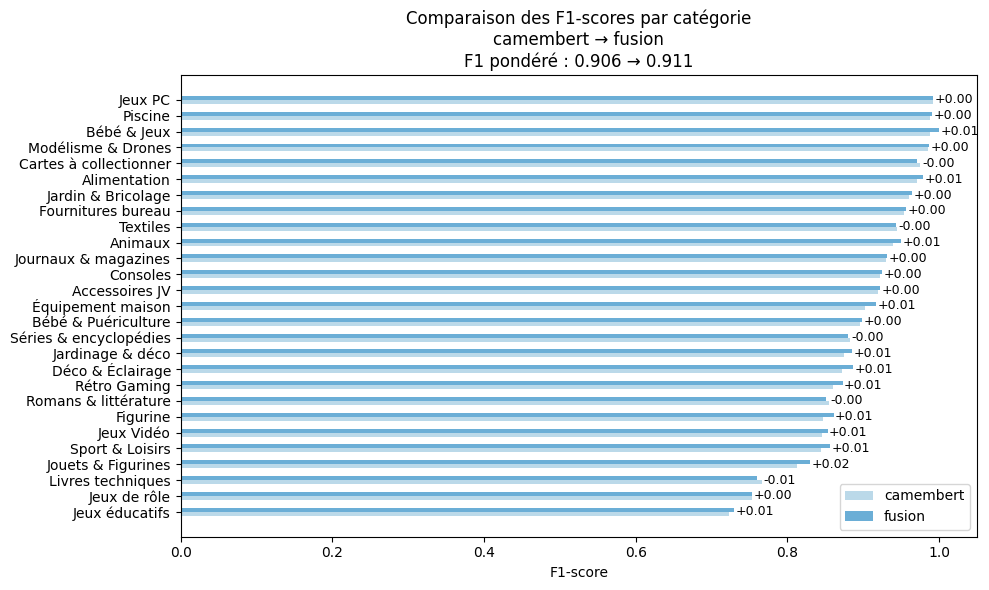

F1 weighted score : 0.911
Accuracy : 0.91


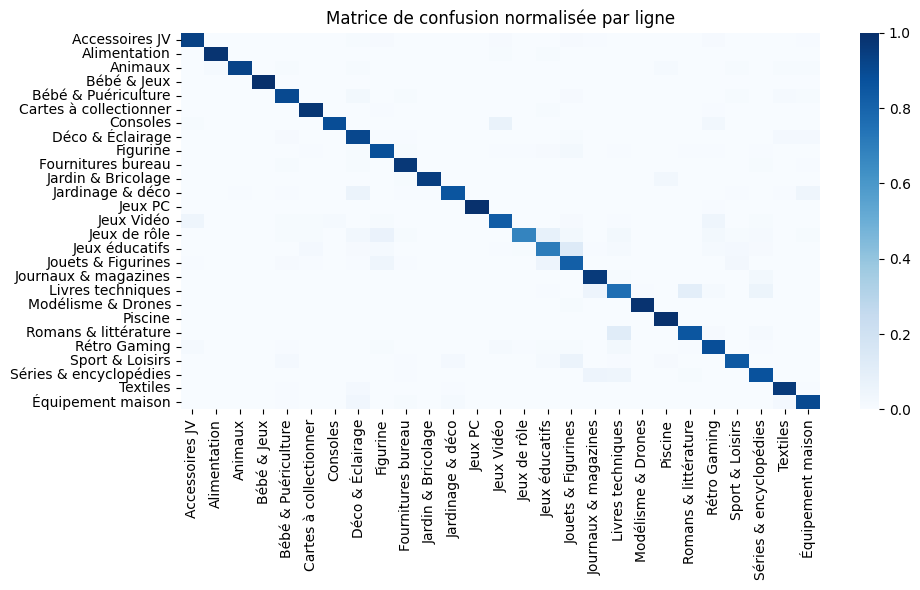

,precision,recall,f1-score,support
Romans & littérature,0.851,0.853,0.852,414.0
Jouets & Figurines,0.843,0.818,0.831,731.0
Livres techniques,0.759,0.760,0.759,467.0
Jeux de rôle,0.848,0.678,0.754,115.0
Jeux éducatifs,0.749,0.711,0.729,311.0


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,13.2
1,Romans & littérature,Livres techniques,11.4
2,Livres techniques,Romans & littérature,9.9
3,Jeux de rôle,Jeux éducatifs,7.8
4,Consoles,Jeux Vidéo,7.2


In [33]:
w_cam, w_xlmr, w_tfidf = df_blending.iloc[2,:3]
P_test = w_cam * P_test_cam + w_xlmr * P_test_xlmr + w_tfidf * P_test_tfidf
y_pred = np.argmax(P_test, axis=1)
y_pred_cam = np.argmax(P_test_cam, axis=1)

plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cam, new_name="fusion", ref_name="camembert", encoder=encoder)
plot_classification_report(y_test, y_pred, encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Le modèle texte final, basé sur une stratégie de <b>blending pondéré</b> combinant
<b>CamemBERT-large</b>, <b>XLM-R</b> et des features <b>TF-IDF</b>, obtient un
<b>F1-score pondéré global de 0.911</b> sur le jeu de test final. À titre de
référence, le modèle <b>CamemBERT-large seul</b> atteint un F1-score de
<b>0.906</b>, soit un <b>gain absolu de +0.005</b>.
</p>


<p>
L’analyse détaillée des performances par catégorie met en évidence une
<b>amélioration sur la majorité des classes</b>. Les gains sont particulièrement
marqués sur certaines catégories de taille intermédiaire, telles que
<b>Jouets &amp; Figurines</b>, <b>Déco &amp; Éclairage</b>,
<b>Équipement maison</b>, <b>Rétro Gaming</b> ou encore <b>Animaux</b>, avec des
améliorations de F1-score comprises entre <b>+0.01 et +0.02</b>.
</p>

<p>
Ces catégories bénéficient vraisemblablement de la complémentarité entre
représentations sémantiques profondes (CamemBERT, XLM-R) et signaux lexicaux plus
directs apportés par le TF-IDF, en particulier lorsque les descriptions produits
présentent une forte variabilité de vocabulaire.
</p>

<p>
À l’inverse, quelques catégories présentent une légère dégradation du F1-score,
notamment <b>Livres techniques</b>, <b>Romans &amp; littérature</b> et
<b>Séries &amp; encyclopédies</b>. Ces baisses restent toutefois limitées (de
l’ordre de quelques millièmes) et n’affectent pas la performance globale.
</p>

<p>
Les catégories présentant les F1-scores les plus faibles correspondent
principalement à des classes sémantiquement proches ou présentant des frontières
peu nettes. C’est notamment le cas de <b>Jeux éducatifs</b>,
<b>Jeux de rôle</b>, <b>Livres techniques</b> et
<b>Romans &amp; littérature</b>.
</p>

<p>
L’analyse des confusions met en évidence des erreurs cohérentes d’un point de vue
métier. Par exemple, les <b>Jeux éducatifs</b> sont fréquemment confondus avec
<b>Jouets &amp; Figurines</b>, tandis que les <b>Romans &amp; littérature</b> et
les <b>Livres techniques</b> présentent des confusions croisées liées à des
descriptions textuelles parfois ambiguës ou hybrides.
</p>

<p>
Ces confusions reflètent davantage des <b>zones grises du problème de
classification</b> que des erreurs systématiques du modèle, et constituent des
pistes d’amélioration potentielles (enrichissement des données, signaux
contextuels supplémentaires, ou fusion multimodale plus poussée).
</p>


<h2>V - Conclusion finale</h2>

<p>
Les résultats obtenus sur le jeu de test confirment l’intérêt d’une stratégie de
<b>fusion pondérée simple et robuste</b> pour la classification de produits à
partir du texte. La combinaison de modèles neuronaux complémentaires et de
features lexicaux classiques permet d’améliorer la performance globale sans
introduire de complexité excessive ni de sur-ajustement.
</p>

<p>
Le gain observé, bien que modéré en valeur absolue, est <b>cohérent, stable et
réparti sur un large ensemble de catégories</b>, ce qui valide les choix
méthodologiques effectués tout au long du projet. Le modèle final retenu
constitue ainsi une base solide pour une extension future vers une approche
multimodale intégrant les informations visuelles.
</p>

</div>
